In [13]:
# model selection
from ml.models.clustering import KMeans
from ml.functions.metrics.regression import RMSE
from ml.functions.distance import EuclideanDistance, MahalanobisDistance


# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

## Q1 - K-Means

#### Load dataset

In [2]:
X_quake, _ = load_csv('./datasets/quake.csv', no_output=True)

In [4]:
scaler = MinMaxScaler()
scaler.fit(X_quake)

X_scaled = scaler.transform(X_quake)

### Q1.a - find best K from DB-index with euclidean distance

In [11]:
best_k = None
best_model = None
best_global_db = None

for num_clusters in np.arange(4, 21):
    best_local_k = None
    best_local_db = None
    best_local_model = None
    
    for i in range(20):
        model = KMeans(num_clusters, 500, distance=EuclideanDistance)
        err, centroids = model.fit(X_scaled)

        db = model.db_index(X_scaled)
        
        if best_local_db is None or db < best_local_db:
            best_local_db = db
            best_local_model = model
            best_local_k = num_clusters
    
    if best_global_db is None or best_local_db < best_global_db:
        best_global_k = best_local_k
        best_global_db = best_local_db
        best_global_model = best_local_model

    print(f"[K={num_clusters}] -> DB-index={best_global_db}, ReconstructionError={best_global_model.errors[-1]}")


[K=4] -> DB-index=11.036715093880296, ReconstructionError=2333.986838639289
[K=5] -> DB-index=10.252761367996934, ReconstructionError=3949.5339514519583
[K=6] -> DB-index=8.842515271870512, ReconstructionError=4930.767387581563
[K=7] -> DB-index=8.03439840955557, ReconstructionError=5474.80840895108
[K=8] -> DB-index=8.03439840955557, ReconstructionError=5474.80840895108
[K=9] -> DB-index=8.03439840955557, ReconstructionError=5474.80840895108
[K=10] -> DB-index=7.3489964404555534, ReconstructionError=7155.07131595029
[K=11] -> DB-index=6.994045178343833, ReconstructionError=7725.650351470904
[K=12] -> DB-index=6.850544101914939, ReconstructionError=8378.654052101028
[K=13] -> DB-index=6.25735229569542, ReconstructionError=9105.053530091815
[K=14] -> DB-index=6.107186519333494, ReconstructionError=9727.729366567499
[K=15] -> DB-index=5.861962596069891, ReconstructionError=10176.061590942023
[K=16] -> DB-index=5.861962596069891, ReconstructionError=10176.061590942023
[K=17] -> DB-index=5

#### Best model

In [10]:
print(f"[BEST] -> K={best_global_k}, DB-index={best_global_db}, ReconstructionError={best_global_model.errors[-1]}")

[BEST] -> K=20, DB-index=5.145863716105824, ReconstructionError=13501.627339549654


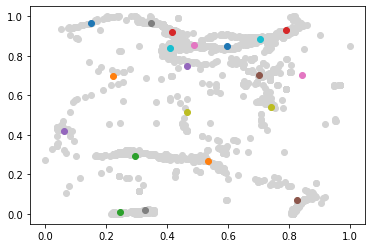

In [12]:
# colors = ['red', 'green']
plt.scatter(X_scaled[:,0], X_scaled[:,1], c='lightgray')

for k in range(best_global_k):
    plt.scatter(best_global_model.centroids[k, 0, 0], best_global_model.centroids[k, 0, 1])
plt.show()

### Q1.b - find best K from DB-index with Mahalanobis distance

## Q2 - PCA

### Prepare dataset

In [120]:
X_penguin, _ = load_csv('./datasets/penguins.csv')

In [121]:
penguin_data_scaler = MinMaxScaler()
penguin_data_scaler.fit(X_penguin)

X_penguin_scaled = penguin_data_scaler.transform(X_penguin)

mean = np.mean(X_penguin_scaled, axis=0, keepdims=True)
X_penguin_centralized = X_penguin_scaled - mean

### SVD decomposition

In [122]:
U, S, V = np.linalg.svd(X_penguin_centralized, full_matrices=True)

### Q2.a - Data projection
A projection matrix P is given by U.T, and a projection is computed by P@S


In [123]:
num_dims = 2

# projection matrix
P = U[:,:num_dims]

# projected dataset
projected_2D = P @ np.diag(S[:num_dims])

# reconstructed dataset
reconstructed_4D = (projected_2D @ P.T) @ U[:,:4]
reconstruction_error = RMSE().measure(X_centralized, reconstructed4D)
print(f"Reconstruction error: {reconstruction_error}")

Reconstruction error: 0.4982738092286141


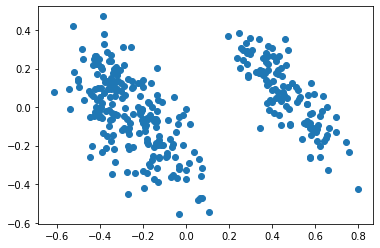

In [124]:
# Plotting 2D projection of the dataset
x_proj = projected_2D[:, 0]
y_proj = projected_2D[:, 1]
plt.scatter(x_proj, y_proj)
plt.show()

### Q2.b - Exaplanable Variance

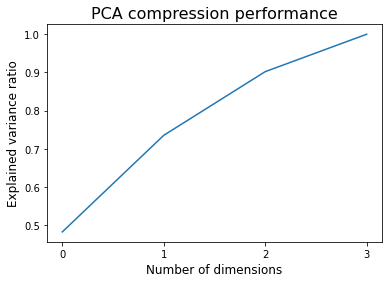

In [125]:
num_dimensions = np.arange(X_centralized.shape[1])

normalized_s = S/np.sum(S)
explainable_variance_ratio = np.cumsum(normalized_s)

# plot
plt.plot(num_dimensions, explainable_variance_ratio)
plt.title("PCA compression performance", size=16)
plt.ylabel("Explained variance ratio", size=12)
plt.xlabel("Number of dimensions", size=12)
plt.xticks(num_dimensions)
plt.show()
